In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex, Markdown
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os
import json
import pandas as pd

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import DDR_f as DDR_f_np
from masa_utils import Pelton_res_f as Pelton_np
from masa_utils import InducedPolarizationSimulation as IPsim_np
from masa_utils import Optimization as Opt_np
from masa_utils import enforce_negative_up, enforce_descending_x

from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, DDR_f, DDC_f, DDP_r_f
from masa_utils_pytorch import Optimization, TorchHelper
 

# impacts of the time range

In [4]:
res0_true= 0.3
res_ref = 0.3
eta_true= 0.4
expc_true= 0.5
tau_true= 1.0e-1 #0.001
taupel = tau_true
tau_rho = tau_true
tau_sig = tau_true*(1-eta_true)**(1/expc_true)
tau_psi = tau_true*(1-eta_true)**(0.5/expc_true)
parm_true = TorchHelper.to_tensor_r([np.log(res0_true), eta_true, np.log(taupel), expc_true])
print(tau_rho, tau_sig, tau_psi)

0.1 0.036 0.06


In [5]:
rho0_refs = np.r_[res_ref, res_ref , res_ref]
eta_ref_pelton= 0.01
tau_refs = np.r_[1e-2, 1]#np.r_[3e-3, 3e-2, 3e-1]
c_refs = np.r_[expc_true, expc_true, expc_true]
parm_refs_pelton = []
nrefs=2
for i in range(nrefs):
    m_ref = TorchHelper.to_tensor_r(
        np.r_[np.log(rho0_refs[i]), eta_ref_pelton, np.log(tau_refs[i]), c_refs[i]]
    )
    parm_refs_pelton.append(m_ref)


In [6]:
parm_refs_pelton

[tensor([-1.2040,  0.0100, -4.6052,  0.5000]),
 tensor([-1.2040,  0.0100,  0.0000,  0.5000])]

In [7]:
nmodel = 2
nband = 2

# taus_start_log = -5*np.ones(nmodel)
# taus_end_log   = [-2, 0, 2]  
freq_strt_log = [0,2]# [2,0,-2]
freq_end_log =  4*np.ones(nmodel)
taus_step_log = [0.5,0.25]# [0.5]
freq_step_log  = 0.1

freq_cmb = []
taus_cmb= []
freq_cmb_bottom = []
freq_cmb_top = []
taus_cmb_top = []
taus_cmb_bottom = []
ntau_cmb = []

tau_refs_list = []
for i in range(nband):
    nfreq = int(round((freq_end_log[i] - freq_strt_log[i]) / freq_step_log)) + 1
    freq = np.logspace(freq_strt_log[i], freq_end_log[i], nfreq, base=10.0)
    for j in range(nmodel):
        assert freq_end_log[j] > freq_strt_log[j]
        ntau = int(round((freq_end_log[i]-freq_strt_log[i]) / taus_step_log[j])) + 1
        taus = np.logspace(-freq_end_log[i], -freq_strt_log[i], ntau, base=10.0) / (2.0*np.pi)

        assert np.isclose(taus.min(), 10**(-freq_end_log[i])/(2.0*np.pi))
        assert np.isclose(taus.max(), 10**(-freq_strt_log[i])/(2.0*np.pi))
        taus_cmb.append(taus)
        ntau_cmb.append(ntau)
    taus_cmb_top.append(taus.max())
    taus_cmb_bottom.append(taus.min())
        
    freq_cmb.append(freq)
    freq_cmb_bottom.append(freq.min())
    freq_cmb_top.append(freq.max())

    tau_refs_list.append(tau_refs)

freq_ext_strt_log = -1
freq_ext_end_log =5
nfreq_ext = int(round((freq_ext_end_log - freq_ext_strt_log) / freq_step_log)) + 1
freq_ext = np.logspace(freq_ext_strt_log, freq_ext_end_log, nfreq_ext, base=10.0)

frq_ext_min, frq_ext_max = freq_ext.min(), freq_ext.max()


In [8]:
freq_ext

array([1.00000000e-01, 1.25892541e-01, 1.58489319e-01, 1.99526231e-01,
       2.51188643e-01, 3.16227766e-01, 3.98107171e-01, 5.01187234e-01,
       6.30957344e-01, 7.94328235e-01, 1.00000000e+00, 1.25892541e+00,
       1.58489319e+00, 1.99526231e+00, 2.51188643e+00, 3.16227766e+00,
       3.98107171e+00, 5.01187234e+00, 6.30957344e+00, 7.94328235e+00,
       1.00000000e+01, 1.25892541e+01, 1.58489319e+01, 1.99526231e+01,
       2.51188643e+01, 3.16227766e+01, 3.98107171e+01, 5.01187234e+01,
       6.30957344e+01, 7.94328235e+01, 1.00000000e+02, 1.25892541e+02,
       1.58489319e+02, 1.99526231e+02, 2.51188643e+02, 3.16227766e+02,
       3.98107171e+02, 5.01187234e+02, 6.30957344e+02, 7.94328235e+02,
       1.00000000e+03, 1.25892541e+03, 1.58489319e+03, 1.99526231e+03,
       2.51188643e+03, 3.16227766e+03, 3.98107171e+03, 5.01187234e+03,
       6.30957344e+03, 7.94328235e+03, 1.00000000e+04, 1.25892541e+04,
       1.58489319e+04, 1.99526231e+04, 2.51188643e+04, 3.16227766e+04,
      

In [9]:
relative_error = 0.02
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


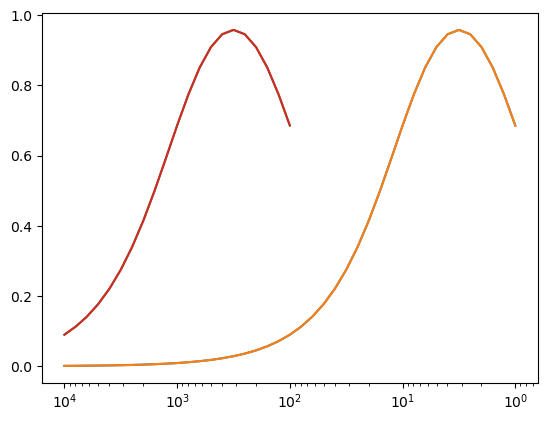

In [10]:
fig, ax = plt.subplots()

dobs_cmb =[]
rho0_recs = []
eta_recs = []
sim_obs = []
sim_invs = []
sim_invs_ext = []
sim_invs_pelton = []
parm_refs = []
noise_floor_cmb = []

IP_model = Pelton(freq=freq_ext)
sim_invs_pelton_ext= InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

for i in range(nband):
    freq = freq_cmb[i]
    nfreq = freq.shape[0]
    IP_model = Pelton(freq=freq)
    sim_obs = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    sim_invs_pelton.append(sim_obs)
    dobs = sim_obs.dpred(parm_true).detach()
    f_abs = abs(IP_model.f(parm_true)).detach().numpy()
    rho0, rho8 = f_abs.max(), f_abs.min()
    rho0_recs.append(rho0)
    eta_recs.append((rho0-rho8)/rho0) 

    dobs_cmb.append(dobs)
    noise_floor = torch.tensor(f_abs.max())* noise_floor_ratio
    noise_floor_cmb.append(noise_floor)

    for j in range(nmodel):
        taus = taus_cmb[nband*i + j]
        ntau = ntau_cmb[nband*i + j]

        IP_model = DDR_f(freq=freq_ext, taus=taus)
        # IP_model = DDP_r_f(freq=freq,taus=taus)
        # IP_model = DDC_f(freq=freq, taus=taus, res=True)
        sim_inv = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

        sim_invs_ext.append(sim_inv)


        IP_model = DDR_f(freq=freq, taus=taus)
        # IP_model = DDP_r_f(freq=freq,taus=taus)
        # IP_model = DDC_f(freq=freq, taus=taus, res=True)
        sim_inv = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

        sim_invs.append(sim_inv)

        parm_init = torch.tensor(
        # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
        np.r_[np.log(f_abs.max()), np.zeros(ntau)],
        dtype=torch.float32,
        requires_grad=True
        ) #, requires_grad=False)
        parm_refs.append(parm_init)
        m= np.r_[np.log(0.3), np.zeros(len(taus)-1), 0.9]
        # m= np.r_[np.log(0.3), 0.9,  np.zeros(len(taus)-1)]
        m_tensor=TorchHelper.to_tensor_r(m)
        dpred = sim_inv.dpred(m_tensor)

        dpred_real = dpred[:nfreq]
        dpred_imag = dpred[nfreq:]
        dpred_phase= np.angle(dpred_real + 1.00j *dpred_imag)
        ax.semilogx(freq, -dpred_phase)
        # ax.axvline(x=(1/2/np.pi)*10**(-taus_end_log), color='gray', linestyle='--')
        # ax.axvline(x=(1/2/np.pi)*10**(-taus_end_log[i]), color='gray', linestyle='--')
ax.invert_xaxis()        
plt.show()

In [11]:
sim =sim_invs[3]
sim.ip_model.taus

tensor([1.5915e-05+0.j, 2.8302e-05+0.j, 5.0329e-05+0.j, 8.9499e-05+0.j, 1.5915e-04+0.j,
        2.8302e-04+0.j, 5.0329e-04+0.j, 8.9499e-04+0.j, 1.5915e-03+0.j])

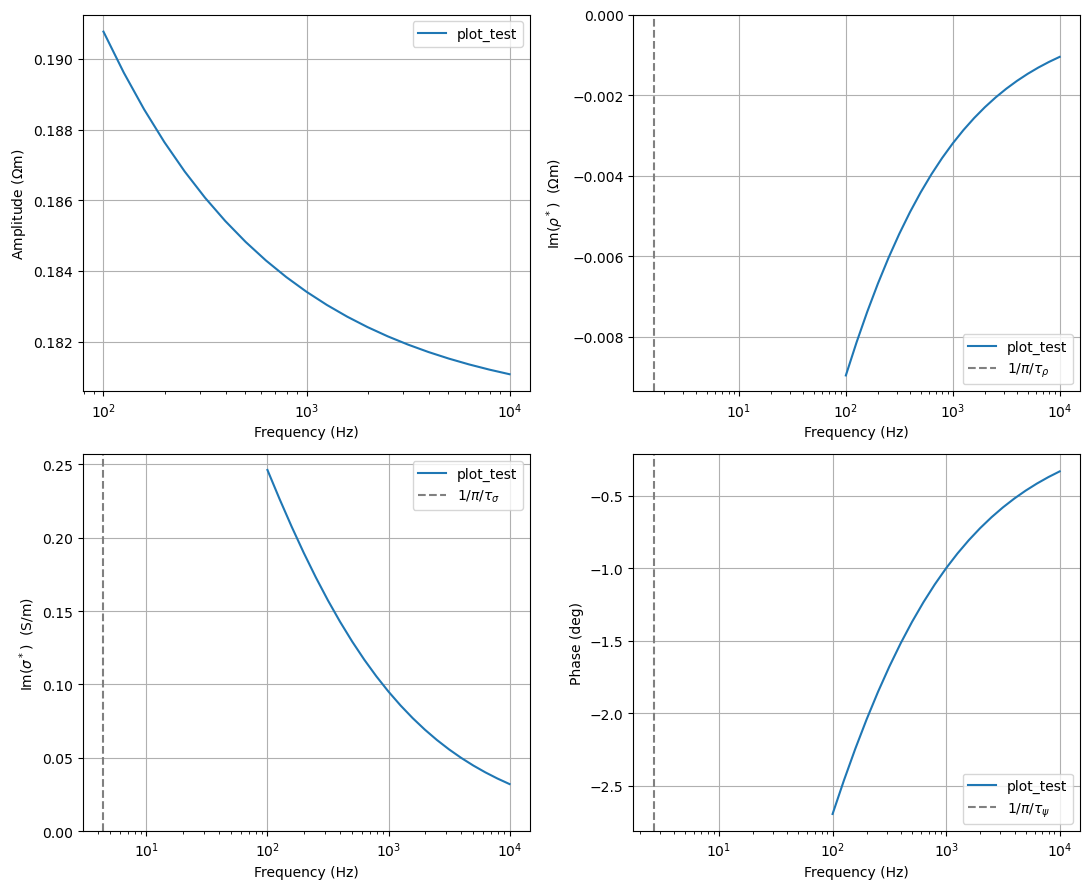

In [12]:
sim_inv = sim_invs_pelton[1]
fig, ax = plt.subplots(2, 2, figsize=(11, 9))
ax = ax.ravel()
ax = [None, ax[1], ax[2], ax[0], ax[3], None]

sim_inv.plot_sip_model(parm_true,label='plot_test', magphs=False,ax=ax)
ax[1].axvline(x=1/2/np.pi/tau_rho, color='gray', linestyle='--', label=r'$1/\pi/\tau_\rho$')
ax[2].axvline(x=1/2/np.pi/tau_sig, color='gray', linestyle='--', label=r'$1/\pi/\tau_\sigma$')
ax[4].axvline(x=1/2/np.pi/tau_psi, color='gray', linestyle='--', label=r'$1/\pi/\tau_\psi$')

plt.tight_layout()
for a in ax:
    if a is not None:
        a.legend()
        a.grid()

In [13]:
dinit_refs = []
model_recs = []
dpreds = []
error_prgs = []
model_prgs = []
data_prgs =[]

WdJs = []
J_etas_prd = []

model_recs_pelton = []
dpreds_pelton = []
error_prgs_pelton = []
model_prgs_pelton = []
data_prgs_pelton =[]

for i in range(nband):
    freq = freq_cmb[i]
    nfreq = freq.shape[0]
    dobs = dobs_cmb[i]
    noise_floor = noise_floor_cmb[i]
    print(nfreq, len(dobs))


    for j in range(nmodel):
        taus = taus_cmb[i*nmodel + j]
        parm_init = parm_refs[i*nmodel + j]
        sim = sim_invs[i*nmodel + j]

        opt = Optimization(sim=sim, dobs=dobs)
        opt.get_Wd(ratio=relative_error, plateau=noise_floor)

        jacobian = opt.J(parm_refs[i*nmodel + j])
        WdJs.append(opt.Wd@jacobian)
        J_etas_prd.append(sim.J_prd(opt.Wd@jacobian))

        opt.Ws = torch.eye(len(parm_init))
        beta0 = opt.BetaEstimate_byEig(eig_tol=1e-6,
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
        print(beta0)
        mpred = opt.GaussNewton(
        mvec_init=parm_init,niter=niter,beta0=beta0,L1reg=False,
        coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        stol=stol,update_Wsen=True)

        dinit_refs.append(opt.dpred(parm_init))
        model_recs.append(mpred)
        dpreds.append(opt.dpred(mpred))
        error_prgs.append(opt.error_prg)
        model_prgs.append(opt.mvec_prg)
        data_prgs.append(opt.data_prg)

    sim = sim_invs_pelton[i]
    for j in range(nrefs):
        opt= Optimization(sim=sim, dobs=dobs)
        opt.get_Wd(ratio=relative_error, plateau=noise_floor)
        m_ref = parm_refs_pelton[j]
        opt.Ws = torch.eye(len(m_ref))
        beta0 = opt.BetaEstimate_byEig(eig_tol=1e-6,
        m=m_ref,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
        mpred_pelton = opt.GaussNewton(
        mvec_init=m_ref,niter=niter,beta0=beta0,L1reg=False,
        coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        stol=stol,update_Wsen=True)
        model_recs_pelton.append(mpred_pelton)
        dpreds_pelton.append(opt.dpred(mpred_pelton))
        error_prgs_pelton.append(opt.error_prg)
        model_prgs_pelton.append(opt.mvec_prg)
        data_prgs_pelton.append(opt.data_prg)



41 82
tensor(76152720.)
  0, beta:7.6e+07, phid:4.7e+04,    phim:0.0e+00, f:4.7e+04
  1, beta:7.6e+07, step:1.0e+00, gradient:8.1e+05, f:4.0e+04
  2, beta:7.6e+07, step:1.0e+00, gradient:8.9e+04, f:4.0e+04
  3, beta:3.8e+07, step:1.0e+00, gradient:3.3e+05, f:3.4e+04
  4, beta:3.8e+07, step:1.0e+00, gradient:6.4e+04, f:3.4e+04
  5, beta:1.9e+07, step:1.0e+00, gradient:2.9e+05, f:2.7e+04
  6, beta:1.9e+07, step:1.0e+00, gradient:9.0e+04, f:2.7e+04
  7, beta:9.5e+06, step:1.0e+00, gradient:2.4e+05, f:2.0e+04
  8, beta:9.5e+06, step:1.0e+00, gradient:1.1e+05, f:1.9e+04
  9, beta:4.8e+06, step:1.0e+00, gradient:1.9e+05, f:1.3e+04
 10, beta:4.8e+06, step:1.0e+00, gradient:1.2e+05, f:1.2e+04
 11, beta:2.4e+06, step:1.0e+00, gradient:1.7e+05, f:8.1e+03
 12, beta:2.4e+06, step:1.0e+00, gradient:1.3e+05, f:7.7e+03
 13, beta:1.2e+06, step:1.0e+00, gradient:1.5e+05, f:5.0e+03
 14, beta:1.2e+06, step:1.0e+00, gradient:1.4e+05, f:4.8e+03
 15, beta:5.9e+05, step:1.0e+00, gradient:1.5e+05, f:3.2e+03
 

In [14]:
phid_star_ratio =1.0
models_rec_phid = []
dpreds_phid = []
models_rec_phid_pelton = []
dpreds_phid_pelton = []

for i in range(nband):
    freq = freq_cmb[i]
    nfreq = freq.shape[0]
    phid_star = nfreq*2
    for j in range(nmodel):    
        sim = sim_invs[i*nmodel + j]
        model_prg= np.array(model_prgs[i*nmodel + j])
        data_prg = np.array(data_prgs[i*nmodel + j])
        error_prg = error_prgs[i*nmodel + j]
        phid_prg = np.array(error_prg)[:,1]
        ind = phid_prg < phid_star * phid_star_ratio
        if np.sum(ind) == 0:
            ind = phid_prg == np.min(phid_prg)
        models_rec_phid.append(model_prg[ind][0])
        model_rec = TorchHelper.to_tensor_r(model_prg[ind][0])
        dpred = sim.dpred(model_rec)
        dpreds_phid.append(dpred.detach().numpy())
    sim = sim_invs_pelton[i]
    for j in range(nrefs):
        model_prg_pelton= np.array(model_prgs_pelton[i*nrefs + j])
        data_prg_pelton = np.array(data_prgs_pelton[i*nrefs + j])
        error_prg_pelton = error_prgs_pelton[i*nrefs + j]
        phid_prg_pelton = np.array(error_prg_pelton)[:,1]
        ind = phid_prg_pelton < phid_star * phid_star_ratio
        if np.sum(ind) == 0:
            ind = phid_prg_pelton == np.min(phid_prg_pelton)
        models_rec_phid_pelton.append(model_prg_pelton[ind][0])
        model_rec = TorchHelper.to_tensor_r(model_prg_pelton[ind][0])
        dpred = sim.dpred(model_rec)
        dpreds_phid_pelton.append(dpred.detach().numpy())
    # dpreds_phid.append(data_prg[ind][0])


In [15]:
rho0_invs_dd = []
eta_invs_dd = []
rho0_invs_pel = []
rho0_mins_pel = []
rho0_maxs_pel = []
eta_invs_pel = []
eta_mins_pel = []
eta_maxs_pel = []
tau_invs_pel = []
tau_mins_pel = []
tau_maxs_pel = []
c_invs_pel = []
c_mins_pel = []
c_maxs_pel = []

for i in range(nband):

    for j in range(nmodel):
        taus = taus_cmb[i*nmodel + j]
        model_dd = models_rec_phid[i*nmodel + j]
        rho0 = np.exp(model_dd[0].item())
        eta = model_dd[1:].sum().item()
        print(f"model_dd {j}: rho0: {rho0:.2e}, eta: {eta:.3f}")

        rho0_invs_dd.append(rho0)
        eta_invs_dd.append(eta)


    for j in range(nrefs):
        model_pelton = models_rec_phid_pelton[i*nrefs + j]
        rho0 = np.exp(model_pelton[0].item())
        eta = model_pelton[1].item()
        tau = np.exp(model_pelton[2].item())
        c = model_pelton[3].item()

        print(f"model_pelton {i}, ref {j}: rho0: {rho0:.2e}, eta: {eta:.3f}, tau: {tau:.2e}, c: {c:.3f}")

        rho0_invs_pel.append(rho0)
        eta_invs_pel.append(eta)
        tau_invs_pel.append(tau)
        c_invs_pel.append(c)



model_dd 0: rho0: 2.67e-01, eta: 0.324
model_dd 1: rho0: 2.68e-01, eta: 0.326
model_pelton 0, ref 0: rho0: 2.87e-01, eta: 0.373, tau: 6.96e-02, c: 0.525
model_pelton 0, ref 1: rho0: 2.90e-01, eta: 0.376, tau: 7.27e-02, c: 0.531
model_dd 0: rho0: 2.00e-01, eta: 0.101
model_dd 1: rho0: 2.00e-01, eta: 0.099
model_pelton 1, ref 0: rho0: 2.31e-01, eta: 0.220, tau: 1.07e-02, c: 0.568
model_pelton 1, ref 1: rho0: 2.70e-01, eta: 0.332, tau: 5.48e-02, c: 0.484


In [16]:
def sci_latex(v, prec=2):
    s = f"{v:.{prec}e}"          # e.g. '3.00e-03'
    mant, exp = s.split('e')     # '3.00', '-03'
    exp = int(exp)               # remove leading zeros
    if float(mant) == 0:
        return "0"
    if exp == 0:
        return f"{mant}"
    if exp != 0:
        return rf"${mant}\cdot 10^{{{exp}}}$"


In [17]:
rho0_print =[]
eta_print =[]
ntau_print =[]
rho0_recs_print =[]
eta_recs_print =[]
for i in range(nband):
    
    for j in range(nmodel):
        rho0_print.append(rho0_invs_dd[i*nmodel + j])
        eta_print.append(eta_invs_dd[i*nmodel + j])
        ntau_print.append(ntau_cmb[i*nmodel + j])
        rho0_recs_print.append(rho0_recs[i])
        eta_recs_print.append(eta_recs[i])

taurange_print = []
freqrange_print = []
for i in range(nband):
    taurange_print.append(np.r_[taus_cmb_bottom[i], taus_cmb_top[i]])
    freqrange_print.append(np.r_[freq_cmb_bottom[i], freq_cmb_top[i]])

ntau_print = []
for i in range(nband):
    ntau_print_band = []
    for j in range(nmodel):
        taus = taus_cmb[i*nmodel + j]
        ntau = len(taus)
        ntau_print.append(ntau)



In [18]:
print(r" frequency band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in freqrange_print
      )
       + r"} \\"
)



print(r" $\tau_k$ band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in taurange_print
      )
       + r"} \\"
)


print("\hline")


print(" n & "
      +" & ".join(f"{v: }" for v in ntau_print
      )
       + r"\\"
)


print(r"$\rho_0$ & "
      +" & ".join(f"{v: .2f}" for v in  rho0_print)
       + r"\\"
)

print(r"$\rho (\min(f))$ & "
      +" & ".join(f"{v:.2f}" for v in rho0_recs_print)
       + r"\\"
)


print(r"$\sum\eta_k$ & "
      +" & ".join(f"{v:.2f}" for v in eta_print)
     + r"\\"
)

print(r" $1-\frac{\rho (\max(f))}{\rho (\min(f))}$ & "
      +" & ".join(f"{v:.2f}" for v in eta_recs_print)
       + r"\\"
)



 frequency band & \multicolumn{2}{c|}{1.0 to $1.0\cdot 10^{4}$} & \multicolumn{2}{c|}{$1.0\cdot 10^{2}$ to $1.0\cdot 10^{4}$} \\
 $\tau_k$ band & \multicolumn{2}{c|}{$1.6\cdot 10^{-5}$ to $1.6\cdot 10^{-1}$} & \multicolumn{2}{c|}{$1.6\cdot 10^{-5}$ to $1.6\cdot 10^{-3}$} \\
\hline
 n &  9 &  17 &  5 &  9\\
$\rho_0$ &  0.27 &  0.27 &  0.20 &  0.20\\
$\rho (\min(f))$ & 0.25 & 0.25 & 0.19 & 0.19\\
$\sum\eta_k$ & 0.32 & 0.33 & 0.10 & 0.10\\
 $1-\frac{\rho (\max(f))}{\rho (\min(f))}$ & 0.27 & 0.27 & 0.05 & 0.05\\


In [19]:
rho0_print =[]
eta_print =[]
tau_print =[]
c_print =[]

rho0_print.append(res0_true)
eta_print.append(eta_true)
tau_print.append(tau_true)
c_print.append(expc_true)

for i in range(nband):
    for j in range(nrefs):
        rho0_print.append(rho0_refs[j])
        rho0_print.append(rho0_invs_pel[i*nrefs + j])
        eta_print.append(eta_ref_pelton)
        eta_print.append(eta_invs_pel[i*nrefs + j])
        tau_print.append(tau_refs[j])
        tau_print.append(tau_invs_pel[i*nrefs + j])
        c_print.append(c_refs[j])
        c_print.append(c_invs_pel[i*nrefs + j])



In [39]:
print(r" \multicolumn{2}{c|}{frequency band} &  \multicolumn{4}{c|}{"
      + r"}&  \multicolumn{4}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in freqrange_print
      )
       + r"} \\"
)
print("\hline")

titles = []
for i in range(nband):
    for j in range(nrefs):
        titles.append(f"inversion {j+1}")

print(r" & & \multicolumn{2}{c|}{" 
      + r"} & \multicolumn{2}{c|}{ ".join(
          s for s in titles) 
+  r" }\\"
)

print("\hline")

titles = []
titles.append("true")
for i in range(nband):
    for j in range(nrefs):
        titles.append("ref")
        titles.append("inv")
print(" & " + " & ".join(s for s in titles) +  r"\\")

print(r"$\rho_0$ & "
      +" & ".join(f"{v: .2f}" for v in rho0_print
      )
      + r"\\"
)

print(r"$\eta$ & "
      +" & ".join(f"{v:.2f}" for v in eta_print
      )
       + r"\\"
)     
print(r"$\tau_\rho$ & "
      + " & ".join(sci_latex(v, 1) for v in tau_print
      )
      + r"\\"
)

print(" C & "
      +" &".join(f"{v:.2f}" for v in c_print
      )
      + r"\\"
)


 \multicolumn{2}{c|}{frequency band} &  \multicolumn{4}{c|}{1.0 to $1.0\cdot 10^{4}$}&  \multicolumn{4}{c|}{$1.0\cdot 10^{2}$ to $1.0\cdot 10^{4}$} \\
\hline
 & & \multicolumn{2}{c|}{inversion 1} & \multicolumn{2}{c|}{ inversion 2} & \multicolumn{2}{c|}{ inversion 1} & \multicolumn{2}{c|}{ inversion 2 }\\
\hline
 & true & ref & inv & ref & inv & ref & inv & ref & inv\\
$\rho_0$ &  0.30 &  0.30 &  0.29 &  0.30 &  0.29 &  0.30 &  0.23 &  0.30 &  0.27\\
$\eta$ & 0.40 & 0.01 & 0.37 & 0.01 & 0.38 & 0.01 & 0.22 & 0.01 & 0.33\\
$\tau_\rho$ & $1.0\cdot 10^{-1}$ & $1.0\cdot 10^{-2}$ & $7.0\cdot 10^{-2}$ & 1.0 & $7.3\cdot 10^{-2}$ & $1.0\cdot 10^{-2}$ & $1.1\cdot 10^{-2}$ & 1.0 & $5.5\cdot 10^{-2}$\\
 C & 0.50 &0.50 &0.52 &0.50 &0.53 &0.50 &0.57 &0.50 &0.48\\


In [21]:
def plot_etas_model(model,taus,twin=True, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax1 = ax
    default_kwargs_1 = {
        "linestyle": "",
        "marker": "o",
        "markersize": 4,
    }

    default_kwargs_2 = {
        "linestyle": "-",
    }

    default_kwargs_1.update(kwargs)
    default_kwargs_2.update(kwargs)
    etas = TorchHelper.to_numpy_r(model[1:])
    ax1.semilogx(taus, etas, **default_kwargs_1)
    ax1.set_xlabel(r"$\tau_k$ [s]")
    ax1.set_ylabel(r"$\eta_k$")
    if twin:
        ax2 = ax1.twinx()
        ax2.semilogx(taus, np.cumsum(etas), **default_kwargs_2)
        ax2.set_ylabel(r"$\sum_j^{k} \eta_j$")

    return ax1

In [22]:
def plot_etas_cum(model,taus, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas = TorchHelper.to_numpy_r(model[1:])
    ax.semilogx(taus, np.cumsum(etas), **kwargs)
    ax.set_xlabel(r"$\tau_k$ [s]")
    ax.set_ylabel(r"$\Sigma\!_{j,k}\,\eta_j$")
    return ax

In [23]:
column_labels = ["1", "2", "3"]

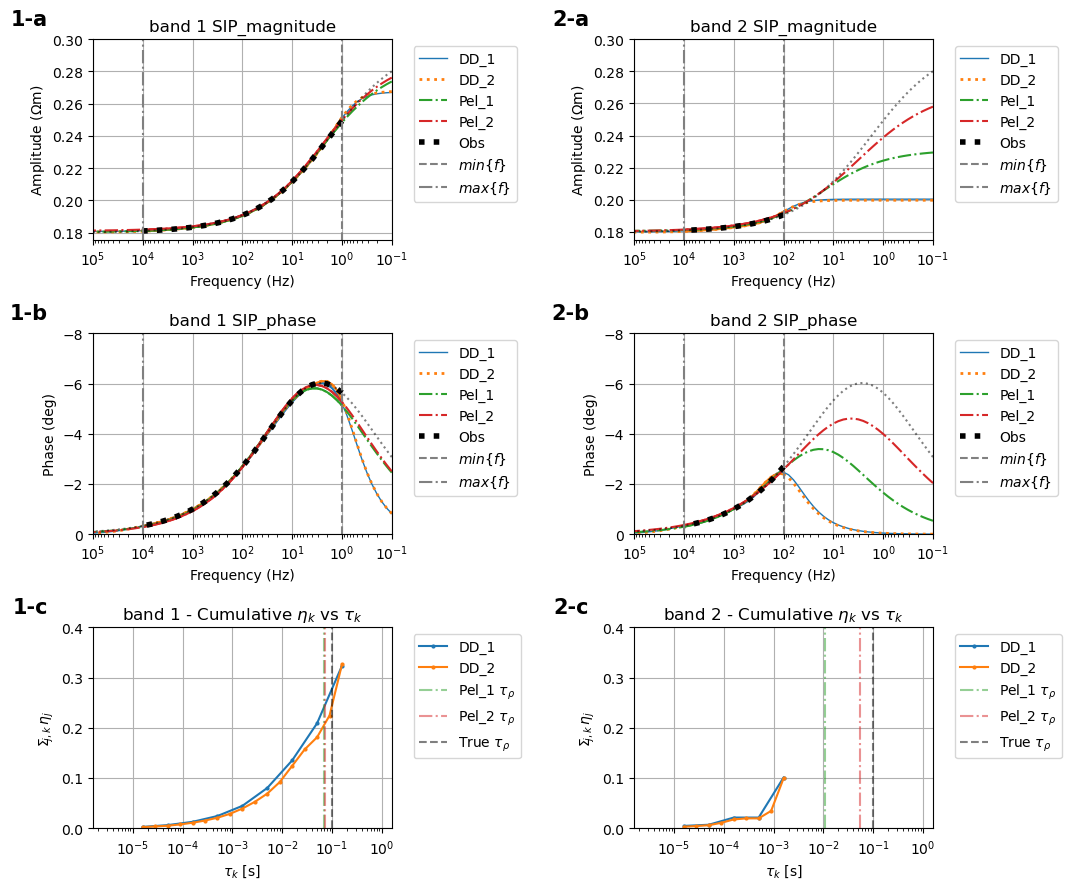

In [24]:
fig, ax = plt.subplots(3, nmodel, figsize=(11,9))
title_heads = ["band 1", "band 2", "band 3"]
ax_ranges = []
for i in range(nband):
    ax_ranges.append([ax[0, i], ax[1, i], ax[2, i]])
for i in range(nband):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axsip = [ax_range[0], ax_range[1]]
    dobs = dobs_cmb[i]
    for j in range(nmodel):
        sim_dd = sim_invs[i*nmodel + j]
        model_dd = models_rec_phid[i*nmodel + j]
        model_dd = TorchHelper.to_tensor_r(model_dd)
        axetas = ax_range[2]
        axsip = sim_dd.plot_sip_model( model_dd, 
                ax=axsip, color=f"C{j}",linestyle="-"
                )
        sim_dd_ext = sim_invs_ext[i*nmodel + j]
        if j ==0:
            linestyle="-"
            linewidth=1
        else:
            linestyle=":"
            linewidth=2
        axsip = sim_dd_ext.plot_sip_model( model_dd, 
            ax=axsip, color=f"C{j}", linestyle=linestyle, linewidth=linewidth
            , label=f"DD_{j+1}" )
        # axetas = plot_etas_model(models_rec_phid[i*nmodel+j], taus_cmb[i*nmodel+j],
        #         ax=axetas, color=f"C{j}", label=f"DD_{j+1}", linestyle="-",
        #         marker=".", markersize= 4.
        #         )
        axetas = plot_etas_cum(models_rec_phid[i*nmodel+j], taus_cmb[i*nmodel+j],
                ax=axetas, color=f"C{j}", label=f"DD_{j+1}", linestyle="-",
                marker=".", markersize= 4.
                )

    sim_pelton = sim_invs_pelton[i]
    for j in range(nrefs):
        model_pelton = models_rec_phid_pelton[i*nrefs + j]
        model_pelton = TorchHelper.to_tensor_r(model_pelton)
        axsip = sim_pelton.plot_sip_model(
            model_pelton,
            ax=axsip,
            color=f"C{nmodel+j}",
            linestyle="-"
        )
        axsip = sim_invs_pelton_ext.plot_sip_model(
            model_pelton,
            ax=axsip,
            color=f"C{nmodel+j}",
            label=f"Pel_{j+1}",
            linestyle="-."
        )
        tau_pelton = np.exp(model_pelton[2].item())
        axetas.axvline(x=tau_pelton, color=f"C{nmodel+j}", linestyle="-.",
            label=fr"Pel_{j+1} $\tau_\rho$", alpha=0.5,
        )

                           
    axetas.axvline(x=tau_true, color=f"k", linestyle="--",
        label=fr"True $\tau_\rho$", alpha=0.5,
    )

    sim = sim_invs_pelton[i]
    axsip  = sim.plot_sip_model(parm_true,
             ax=axsip, color=f"k", label=f"Obs", linestyle=":",
             linewidth = 4
              )
    sim = sim_invs_pelton_ext
    axsip  = sim.plot_sip_model(parm_true,
                ax=axsip, color=f"k", linestyle=":",
                alpha=0.5,
                )
            
    # axetas = plot_etas_model(models_rec_phid[i+nrange], taus_cmb[i+nrange],
    #          ax=axetas, color="C1", label=f"True", linestyle=":" ,
    #          marker=".", markersize= 4.
    #         )

    axsip[0].set_ylim(top=0.30)
    axsip[0].set_xlim(left=frq_ext_max, right=frq_ext_min)
    axsip[1].set_ylim(bottom=0, top= -8)
    axsip[1].set_xlim(left=frq_ext_max, right=frq_ext_min)
    axsip[0].axvline(x=freq_cmb_bottom[i], color='gray', linestyle='--', label=r'$min\{f\}$')
    axsip[1].axvline(x=freq_cmb_bottom[i], color='gray', linestyle='--', label=r'$min\{f\}$')
    axsip[0].axvline(x=freq_cmb_top[i], color='gray', linestyle='-.', label=r'$max\{f\}$')
    axsip[1].axvline(x=freq_cmb_top[i], color='gray', linestyle='-.', label=r'$max\{f\}$')
    axetas.set_xlim(left=1/2/np.pi/frq_ext_max, right=1/2/np.pi/frq_ext_min)
    axetas.set_ylim(top=0.40, bottom=0)

    for a in ax_range:
        a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # a.legend()
        a.grid()
    ax_range[0].set_title(f"{title_head} SIP_magnitude")
    ax_range[1].set_title(f"{title_head} SIP_phase")
    # ax_range[2].set_title(fr"{title_head} - $\eta_k$ vs $\tau_k$")
    ax_range[2].set_title(fr"{title_head} - Cumulative $\eta_k$ vs $\tau_k$")

    column_label = column_labels[i]
    low_names= ['-a', '-b', '-c']

    for label, axis in zip(low_names, ax_range):
        axis.text(
            -0.15, 1.05, f"{column_label}{label}",
            transform=axis.transAxes,
            fontsize=15, fontweight='bold',
            va='bottom', ha='right'
        )


plt.tight_layout()
plt.savefig('42_DD_SIP.jpg', dpi=300)
plt.savefig("42_DD_SIP.pdf", bbox_inches="tight")


In [25]:
parm_true

tensor([-1.2040,  0.4000, -2.3026,  0.5000])

In [26]:
Cnds= []
for i in range(nmodel):
    WdJ = WdJs[i].detach().numpy()
    U, S, V = np.linalg.svd(WdJ)
    S_norm = S / np.max(S)
    Cnds.append(S_norm)


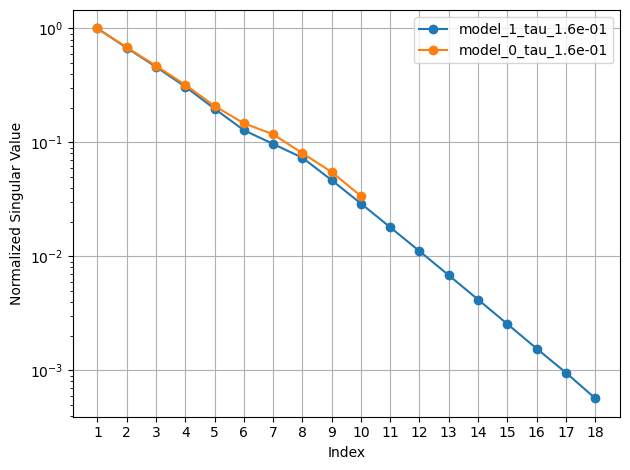

In [27]:
labels= [f""]
index_max=0
for i in np.arange(nmodel-1,-1,-1):
    Cnd = Cnds[i]
    plt.semilogy(Cnd, marker="o",
                 label =f'model_{i}_tau_{taus_cmb[i].max():.1e}')
    index_max = max(index_max, len(Cnd))

plt.xticks(np.arange(index_max), np.arange(1, index_max+1))
plt.xlabel("Index")
plt.ylabel("Normalized Singular Value")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('42_DD_Cnd.jpg', dpi=300)

In [28]:
array = np.arange(4,-1,-1)
print(array)

[4 3 2 1 0]


In [29]:
180*(0.4/np.pi)

22.91831180523293

Repeat with numpy 